## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# TODO - your code!

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
#read in data set

column_names = ['Class Name', 'handicapped-infants', 'water-project-cost-sharing',
                         'adopotion-of-the-budget-resolution', 'physician-fee-freeze',
                         'el-salvaldor-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban', 
                         'aid-to-nicaraguan-contras', 'mx-missile', 'immigration', 
                         'synfuels-corporation-cutback', 'education-spending',
                         'superfund-right-to-sue', 'crime', 'duty-free-exports',
                         'export-administration-act-south-africa']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names=column_names)

df.head()

,Class Name,handicapped-infants,water-project-cost-sharing,adopotion-of-the-budget-resolution,physician-fee-freeze,el-salvaldor-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [25]:
#convert to 1, 0 and NaN

df = df.replace({'y': 1, 'n': 0, "?": np.NaN})
print(df.shape)
df.head()

(435, 17)


,Class Name,handicapped-infants,water-project-cost-sharing,adopotion-of-the-budget-resolution,physician-fee-freeze,el-salvaldor-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [63]:
df.describe()

,handicapped-infants,water-project-cost-sharing,adopotion-of-the-budget-resolution,physician-fee-freeze,el-salvaldor-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,423.000000,387.000000,424.000000,424.000000,420.000000,424.000000,421.000000,420.00000,413.000000,428.000000,414.000000,404.000000,410.000000,418.000000,407.000000,331.000000
mean,0.442080,0.503876,0.596698,0.417453,0.504762,0.641509,0.567696,0.57619,0.501211,0.504673,0.362319,0.423267,0.509756,0.593301,0.427518,0.812689
std,0.497222,0.500632,0.491140,0.493721,0.500574,0.480124,0.495985,0.49475,0.500605,0.500563,0.481252,0.494690,0.500516,0.491806,0.495327,0.390752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
#filter data set into democrate and republican

rep = df[df['Class Name']=='republican']

print(rep.shape)
rep.describe()

(168, 17)


,handicapped-infants,water-project-cost-sharing,adopotion-of-the-budget-resolution,physician-fee-freeze,el-salvaldor-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,165.000000,148.000000,164.000000,165.000000,165.000000,166.000000,162.000000,157.000000,165.000000,165.000000,159.000000,155.000000,158.000000,161.000000,156.000000,146.000000
mean,0.187879,0.506757,0.134146,0.987879,0.951515,0.897590,0.240741,0.152866,0.115152,0.557576,0.132075,0.870968,0.860759,0.981366,0.089744,0.657534
std,0.391804,0.501652,0.341853,0.109760,0.215442,0.304104,0.428859,0.361010,0.320176,0.498186,0.339643,0.336322,0.347298,0.135649,0.286735,0.476168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
dem = df[df['Class Name']=='democrat']

print(dem.shape)
dem.describe()

(267, 17)


,handicapped-infants,water-project-cost-sharing,adopotion-of-the-budget-resolution,physician-fee-freeze,el-salvaldor-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,258.000000,239.000000,260.000000,259.000000,255.000000,258.000000,259.000000,263.000000,248.000000,263.000000,255.000000,249.000000,252.000000,257.000000,251.000000,185.000000
mean,0.604651,0.502092,0.888462,0.054054,0.215686,0.476744,0.772201,0.828897,0.758065,0.471483,0.505882,0.144578,0.289683,0.350195,0.637450,0.935135
std,0.489876,0.501045,0.315405,0.226562,0.412106,0.500430,0.420224,0.377317,0.429121,0.500138,0.500949,0.352383,0.454518,0.477962,0.481697,0.246956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
def confidence_interval(sample, confidence=.95):
  
  sample = np.array(sample)
  mean = np.mean(sample)
  size = len(sample)

  stderr = np.std(sample, ddof=1) / np.sqrt(size)
  t_stat = stats.t.ppf((1+confidence) / 2.0, size -1)

  margin_of_error = t_stat * stderr

  return mean - margin_of_error, mean, mean + margin_of_error
  

In [86]:
lower_bound, mean, upper_bound = confidence_interval(rep['physician-fee-freeze'].dropna())
print("lower bound:", lower_bound)
print("mean", mean)
print("upper bound:", upper_bound)

lower bound: 0.9710067448304756
mean 0.9878787878787879
upper bound: 1.0047508309271003


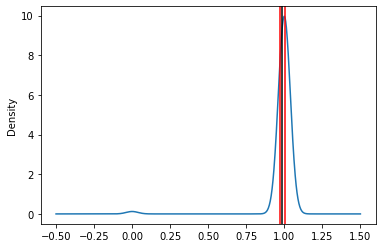

In [87]:
CI = confidence_interval(rep['physician-fee-freeze'].dropna())

rep['physician-fee-freeze'].plot.density(legend=False)
plt.axvline(x=CI[0], color='red')
plt.axvline(x=CI[1], color='black')
plt.axvline(x=CI[2], color='red')
plt.show()


We would say that we are confident that 95% of the confidence intervals created for republican nominees would show a mean support for 'physician fee freeze'  within the range of .97100 and 1.00 (it cannot be higher than 1)  

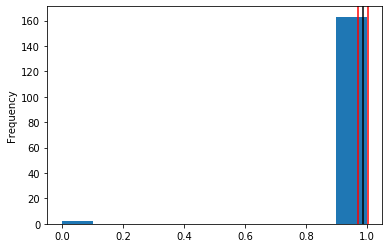

In [89]:
CI = confidence_interval(rep['physician-fee-freeze'].dropna())

rep['physician-fee-freeze'].plot.hist(legend=False)
plt.axvline(x=CI[0], color='red')
plt.axvline(x=CI[1], color='black')
plt.axvline(x=CI[2], color='red')
plt.show()

### CHI SQUARE TEST

In [117]:
iris_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names=iris_names)

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [118]:
#cut petal length to make categorical
 
cut_points = [0, 1, 2, 3, 4, 5, 100]
label_names = ['0-1', '1.1-2', '2.1-3', '3.1-4', '4.1-5', '5.1+']
iris['petal_length'] = pd.cut(iris['petal_length'], cut_points, labels=label_names)

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.1-2,0.2,Iris-setosa
1,4.9,3.0,1.1-2,0.2,Iris-setosa
2,4.7,3.2,1.1-2,0.2,Iris-setosa
3,4.6,3.1,1.1-2,0.2,Iris-setosa
4,5.0,3.6,1.1-2,0.2,Iris-setosa


In [119]:
iris['petal_length'].value_counts()

1.1-2    49
5.1+     42
4.1-5    42
3.1-4    15
2.1-3     1
0-1       1
Name: petal_length, dtype: int64

In [107]:
iris['class'].value_counts()

Iris-versicolor    50
Iris-setosa        50
Iris-virginica     50
Name: class, dtype: int64

In [124]:
#contingency table

contingency_table = pd.crosstab(iris['class'], iris['petal_length'], margins=True)

contingency_table

petal_length,0-1,1.1-2,2.1-3,3.1-4,4.1-5,5.1+,All
class,,,,,,,
Iris-setosa,1,49,0,0,0,0,50
Iris-versicolor,0,0,1,15,33,1,50
Iris-virginica,0,0,0,0,9,41,50
All,1,49,1,15,42,42,150


In [128]:
# need to get the sum of the rows and the sum of the columns

sum_rows = contingency_table.iloc[0:3, 6].values
sum_columns = contingency_table.iloc[3, 0:6].values

print(sum_rows)
print(sum_columns)

[50 50 50]
[ 1 49  1 15 42 42]


In [130]:
#total observations = shape of contigency table

total_total = iris.shape[0]
total_total

150

In [131]:
# make an expected value table 
# column total * row total / the total observations

expected = []
for i in range(len(sum_rows)):
  expected_row = []
  for column in sum_columns:
    expected_val = column*sum_rows[i]/total_total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
print(expected.shape)  
print(expected)


(3, 6)
[[ 0.33333333 16.33333333  0.33333333  5.         14.         14.        ]
 [ 0.33333333 16.33333333  0.33333333  5.         14.         14.        ]
 [ 0.33333333 16.33333333  0.33333333  5.         14.         14.        ]]


In [132]:
#cross tab with no margins for the observed values

observed = pd.crosstab(iris['class'], iris['petal_length']).values
print(observed.shape)
observed

(3, 6)


array([[ 1, 49,  0,  0,  0,  0],
       [ 0,  0,  1, 15, 33,  1],
       [ 0,  0,  0,  0,  9, 41]])

In [133]:
#calculate Chi^2 with array broadcasting

chi_square = ((observed - expected)**2/(expected)).sum()
print(f"chi_square:  {chi_square}")

chi_square:  251.71428571428572


In [0]:
# Degrees of freedom would be equal to categories of v1 -1 multiplied by cat of v2 - 1
# class = 3, petal length = 6
#dof = 2 * 5
#dof = 10



In [134]:
#Calculate Chi_square using scipy

chi_square, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"chi_square: {chi_square}")
print(f"p_value: {p_value}")
print(f"dof: {dof}")
print(f"expected: \n",  np.array(expected))

chi_square: 251.71428571428572
p_value: 2.3667338292637562e-48
dof: 10
expected: 
 [[ 0.33333333 16.33333333  0.33333333  5.         14.         14.        ]
 [ 0.33333333 16.33333333  0.33333333  5.         14.         14.        ]
 [ 0.33333333 16.33333333  0.33333333  5.         14.         14.        ]]


null hypothesis = length of petals and class of iris are independent from each other.
alternate hypothesis = length of petals and class of iris are not independent from eachother

Because the P-value is less than a significance level of really any level, we would reject the null hypothesis and suggest that there is a relationship between length of petals and class of iris

Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data
By hand using Numpy
In a single line using Scipy

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)